### Import libraries

In [1]:
%%capture
#!pip install scanpy
#!pip install KDEpy
#!pip install leidenalg

In [2]:
%%capture
# Remember to restart the kernel once installed
#!pip install -e ../../../tools/nomad/

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy.sparse as sps
from scipy.stats import spearmanr, kendalltau, pearsonr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util as ut
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings

warnings.filterwarnings("ignore")

import importlib
import logging

In [2]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

### Read data

In [43]:
data_path = "../data/S3"
figure_path = f"{data_path}/figures/normalized_counts"
layer = "normalized_counts"

In [44]:
data = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")
data

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt_PCA'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_PCA_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts'
    obsp: 'PCA_connectivities', 'PCA_distances'

### Countsplit

In [45]:
data_train, data_test = cs.countsplit_adata(
    data,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer="counts",
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

Normalize splits

In [46]:
normalization_target_sum = data.obs["total_counts"].median()

In [47]:
data_train.layers["normalized_counts"] = data_train.layers["counts"].copy()
sc.pp.normalize_total(
    data_train, target_sum=normalization_target_sum, layer="normalized_counts"
)

data_test.layers["normalized_counts"] = data_test.layers["counts"].copy()
sc.pp.normalize_total(
    data_test, target_sum=normalization_target_sum, layer="normalized_counts"
)

### Search latent dimension and momentum parameter

In [19]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas_2_check

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In case you don't want to rerun:

In [48]:
k_opt = 1
beta_opt = 0.8

In [20]:
select_cs_results = cs.select_3b_params_countsplit(
    data_train,
    data_test,
    potential_ks=ks_2_check,
    potential_betas=betas_2_check,
    layer=layer,
    maxiters=200,
)

################## LATENT DIM 10


INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 6.479100557044148e-05 loop took 49.95371766900644 overall (0.24976858834503218/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.960898564197123e-05 loop took 45.571890713006724 overall (0.22785945356503362/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8754991944879293e-05 loop took 42.42088877700735 overall (0.21210444388503674/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.863400732167065e-05 loop took 42.22438719798811 overall (0.21112193598994053/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4937005946412683e-05 loop took 50.64832742098952 overall (0.25324163710494757/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.41250270139426e-05 loop took 47.14389918197412 overall (0.2357194959098706/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.67690047621727e-05 loop took 49.2242651960114 overall (0.246121325980057/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7923990273848176e-05 loop took 44.40194056701148 overall (0.2220097028350574/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0257011530920863e-05 loop took 45.620631066994974 overall (0.22810315533497488/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6726978830993176e-05 loop took 44.151144700997975 overall (0.22075572350498987/ea)


################## LATENT DIM 9


INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.496301360428333e-05 loop took 41.49114491598448 overall (0.2074557245799224/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7819012757390738e-05 loop took 45.512771315989085 overall (0.22756385657994543/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.979201963171363e-05 loop took 43.690726807981264 overall (0.2184536340399063/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.617298741824925e-05 loop took 48.92223666101927 overall (0.24461118330509635/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9445014661177993e-05 loop took 41.67731697999989 overall (0.20838658489999942/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.427899744361639e-05 loop took 42.329539054015186 overall (0.21164769527007593/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7503003366291523e-05 loop took 51.35509792002267 overall (0.25677548960011337/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0804978450760245e-05 loop took 47.201757514005294 overall (0.23600878757002647/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6613008230924606e-05 loop took 56.592891014006454 overall (0.28296445507003226/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.994001260958612e-05 loop took 54.891461927996716 overall (0.2744573096399836/ea)


################## LATENT DIM 8


INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.325297777540982e-05 loop took 51.81572138500633 overall (0.25907860692503165/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.704199869185686e-05 loop took 43.90183167500072 overall (0.21950915837500362/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.040200681425631e-05 loop took 41.84180981598911 overall (0.20920904907994553/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6735011488199234e-05 loop took 41.9514644779847 overall (0.2097573223899235/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.648698864504695e-05 loop took 41.77498141201795 overall (0.20887490706008977/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9341026674956083e-05 loop took 47.54404928800068 overall (0.2377202464400034/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.99139937851578e-05 loop took 41.616286122996826 overall (0.20808143061498413/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6214984245598316e-05 loop took 41.192062865011394 overall (0.20596031432505696/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9171991627663374e-05 loop took 41.51123998500407 overall (0.20755619992502033/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6497989892959595e-05 loop took 44.29690301101073 overall (0.22148451505505362/ea)


################## LATENT DIM 7


INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.8619007682427764e-05 loop took 40.766303228010656 overall (0.2038315161400533/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6008987333625555e-05 loop took 40.930402555008186 overall (0.20465201277504094/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4174980353564024e-05 loop took 41.06787308299681 overall (0.20533936541498407/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5917019229382277e-05 loop took 40.542452257999685 overall (0.20271226128999842/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6515015633776784e-05 loop took 40.612065888999496 overall (0.20306032944499747/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0821014661341906e-05 loop took 40.37498992899782 overall (0.2018749496449891/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6563007850199938e-05 loop took 40.3749774399912 overall (0.201874887199956/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7322006644681096e-05 loop took 43.385189713008 overall (0.21692594856504002/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8834998374804854e-05 loop took 44.7035964980023 overall (0.22351798249001148/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7709000278264284e-05 loop took 48.00273558701156 overall (0.2400136779350578/ea)


################## LATENT DIM 6


INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.3213989809155464e-05 loop took 42.96322959300596 overall (0.21481614796502982/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5977991754189134e-05 loop took 45.92186482800753 overall (0.22960932414003765/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.531399463303387e-05 loop took 50.23564116097987 overall (0.25117820580489936/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.356297384016216e-05 loop took 45.80463786001201 overall (0.22902318930006005/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8654001653194427e-05 loop took 47.174026902008336 overall (0.23587013451004168/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.045999958179891e-05 loop took 48.58654159400612 overall (0.2429327079700306/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0319002689793706e-05 loop took 51.12968204397475 overall (0.2556484102198738/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0924013117328286e-05 loop took 47.4330160440004 overall (0.237165080220002/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9587012249976397e-05 loop took 47.693623898987425 overall (0.23846811949493713/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.951401984319091e-05 loop took 50.90068786498159 overall (0.25450343932490793/ea)


################## LATENT DIM 5


INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.1032017432153225e-05 loop took 44.08249824499944 overall (0.2204124912249972/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7550006052479148e-05 loop took 48.177672368998174 overall (0.24088836184499088/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.615701618604362e-05 loop took 46.563869469973724 overall (0.23281934734986862/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9166025342419744e-05 loop took 48.373867311980575 overall (0.24186933655990286/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 6.998301250860095e-05 loop took 46.61292843599222 overall (0.2330646421799611/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.634600969031453e-05 loop took 44.02814948401647 overall (0.22014074742008233/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.072997787967324e-05 loop took 46.28405091102468 overall (0.23142025455512338/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6600988348945975e-05 loop took 43.0915737930045 overall (0.2154578689650225/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.799800131469965e-05 loop took 41.61072708599386 overall (0.2080536354299693/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7834001230075955e-05 loop took 47.58451168600004 overall (0.2379225584300002/ea)


################## LATENT DIM 4


INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.158199251629412e-05 loop took 47.8571914859931 overall (0.2392859574299655/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.8263999158516526e-05 loop took 44.68532456300454 overall (0.2234266228150227/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.060800372622907e-05 loop took 46.847091142990394 overall (0.23423545571495197/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6421010261401534e-05 loop took 46.97869316698052 overall (0.2348934658349026/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6296009309589863e-05 loop took 48.81866106198868 overall (0.2440933053099434/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6475987397134304e-05 loop took 43.21899387901067 overall (0.21609496939505335/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.80920066870749e-05 loop took 39.302401008986635 overall (0.19651200504493319/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.547600888647139e-05 loop took 40.17381398699945 overall (0.20086906993499723/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4779990781098604e-05 loop took 39.09698258701246 overall (0.19548491293506232/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.612600266933441e-05 loop took 43.805868916009786 overall (0.21902934458004894/ea)


################## LATENT DIM 3


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.063201438635588e-05 loop took 38.74226266198093 overall (0.19371131330990465/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.767099067568779e-05 loop took 38.47201658601989 overall (0.19236008293009946/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.667898661457002e-05 loop took 39.65298463500221 overall (0.19826492317501107/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9278977308422327e-05 loop took 38.848698717018124 overall (0.19424349358509063/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.619801671244204e-05 loop took 38.31848292800714 overall (0.1915924146400357/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.680899342522025e-05 loop took 39.01608547201613 overall (0.19508042736008066/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6753987185657024e-05 loop took 38.14506499300478 overall (0.1907253249650239/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.639100421220064e-05 loop took 39.07397848600522 overall (0.1953698924300261/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.971698995679617e-05 loop took 38.653757804015186 overall (0.19326878902007594/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6672001695260406e-05 loop took 44.34019492100924 overall (0.2217009746050462/ea)


################## LATENT DIM 2


INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0430004699155688e-05 loop took 38.182099291996565 overall (0.19091049645998281/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5866000214591622e-05 loop took 37.54901980000432 overall (0.1877450990000216/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.057700814679265e-05 loop took 37.387139450001996 overall (0.18693569725000997/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.423797897994518e-05 loop took 37.483876679005334 overall (0.18741938339502667/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.455299884080887e-05 loop took 36.94463341101073 overall (0.18472316705505365/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7223984943702817e-05 loop took 37.71211401501205 overall (0.18856057007506025/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.039097646251321e-05 loop took 36.80136360300821 overall (0.18400681801504107/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6152003556489944e-05 loop took 37.67139576500631 overall (0.18835697882503155/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.878298982977867e-05 loop took 37.357954487000825 overall (0.18678977243500414/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6169989723712206e-05 loop took 41.30846564201056 overall (0.2065423282100528/ea)


################## LATENT DIM 1


INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.093101597391069e-05 loop took 37.64848459197674 overall (0.1882424229598837/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6410998543724418e-05 loop took 36.593587740993826 overall (0.18296793870496914/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6385998353362083e-05 loop took 37.06952287800959 overall (0.18534761439004796/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.477798261679709e-05 loop took 36.559795308014145 overall (0.1827989765400707/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9328017262741923e-05 loop took 37.282275097997626 overall (0.18641137548998812/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.723999205045402e-05 loop took 36.80861236498458 overall (0.18404306182492292/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5979999918490648e-05 loop took 36.898915472003864 overall (0.1844945773600193/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.288299194537103e-05 loop took 37.169595610990655 overall (0.18584797805495326/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.726502134464681e-05 loop took 36.755180484993616 overall (0.18377590242496808/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5834015104919672e-05 loop took 37.17067392298486 overall (0.1858533696149243/ea)


<Axes: xlabel='k', ylabel='loss'>

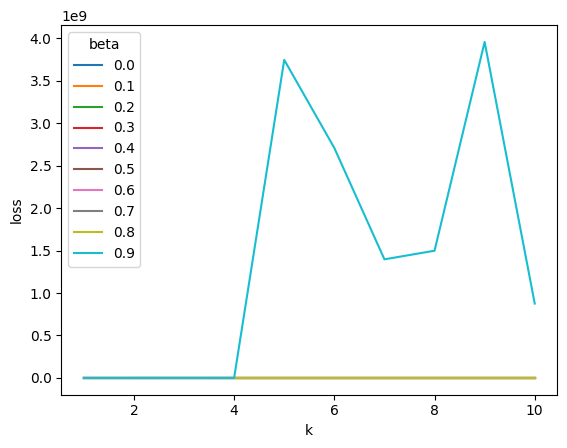

In [21]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [22]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]
k_opt = int(k_opt)
beta_opt = float(beta_opt)

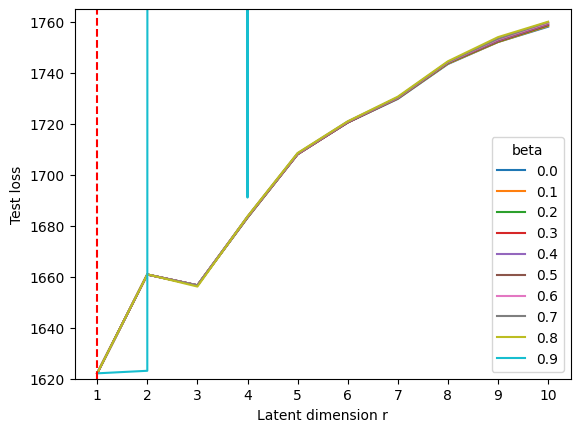

In [31]:
fig, ax = plt.subplots()
latent_dim_search_counts = sns.lineplot(
    data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10"
)
plt.ylabel("Test loss")
plt.xlabel("Latent dimension r")
plt.ylim([1620, 1765])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.axvline(x=k_opt, color="red", linestyle="dashed")

plt.savefig(f"{figure_path}/select_r_beta_cs.svg")
plt.show()

In [28]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 1
Optimal beta: 0.8


In [49]:
data.uns["BacSC_params_NMD"] = {"k_opt": k_opt, "beta_opt": beta_opt}

## Fit NMD with found parameters

In [50]:
n, p = data.X.shape

In [51]:
X_nmd = ut.convert_to_dense(data, layer=layer)
X_nmd = X_nmd.astype(float)
W0, H0 = cs.nuclear_norm_init(X_nmd, n, p, k_opt)
Theta0 = W0 @ H0

In [52]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

In [53]:
kernel_params = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0,
    candidate_factor_H0=H0,
)
nmd_result = nmd.decompose(
    X_nmd,
    k_opt,
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.118502303957939e-05 loop took 42.02813715298544 overall (0.21014068576492717/ea)


In [54]:
data.obsm["X_nmd"] = nmd_result.factors[0]
data.varm["nmd_components"] = nmd_result.factors[1].T
data.layers["Theta_nmd"] = nmd_result.factors[0] @ nmd_result.factors[1]

## Investigate NMD embeddings, "components" and reconstruction

#### Reconstruction

Plot reconstruction of the data before and after fitting NMD.

In [56]:
df_reconstruction_nuclearinit_nmd = pd.DataFrame.from_dict(
    {
        layer: ut.convert_to_dense_counts(data, layer=layer).flatten(),
        "nuclear_init": np.maximum(0, W0 @ H0).flatten(),
        "3B-NMD": np.maximum(
            0, data.obsm["X_nmd"] @ data.varm["nmd_components"].T
        ).flatten(),
    }
)

max_val = max(
    np.max(df_reconstruction_nuclearinit_nmd[layer]),
    np.max(df_reconstruction_nuclearinit_nmd["nuclear_init"]),
    np.max(df_reconstruction_nuclearinit_nmd["3B-NMD"]),
)

corr_orig_nuclear = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["nuclear_init"],
)[0][1]
corr_orig_3bnmd = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["3B-NMD"],
)[0][1]

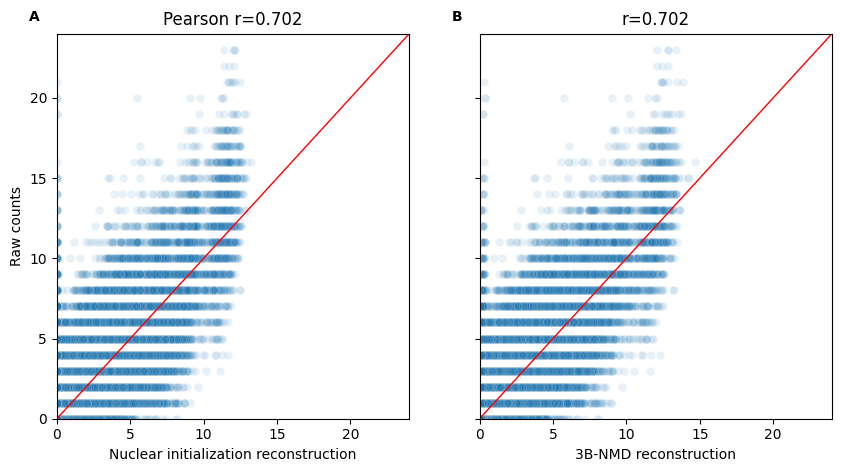

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="nuclear_init", alpha=0.1, ax=ax1
)
ax1.set_title(f"Pearson r={corr_orig_nuclear:.3f}")
ax1.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
ax1.set_ylim((0, max_val + 1))
ax1.set_xlim((0, max_val + 1))
ax1.set_ylabel("Raw counts")
ax1.set_xlabel("Nuclear initialization reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="3B-NMD", alpha=0.1, ax=ax2
)
ax2.set_title(f"r={corr_orig_3bnmd:.3f}")
ax2.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
# ax2.set_ylim((0, max_val))
# ax2.set_xlim((0, max_val))
ax2.set_ylabel(None)
ax2.set_xlabel("3B-NMD reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

# plt.savefig(f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.svg", format="svg")
plt.savefig(
    f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.png", format="png", dpi=300
)
plt.show()

#### NMD embeddings: before and after fitting

Comparison of NMD embeddings before (results of nuclear initialization) and after fitting NMD

In [58]:
W0_length = len(W0[:, 0:1].flatten())
dict_histogram_W0nuclear_vs_W_nmd = {
    "dim_1": np.concatenate((W0[:, 0:1], data.obsm["X_nmd"][:, 0:1])).flatten(),
    "W0_W_nmd": ["W0 (nuclear init.)"] * W0_length + ["W (3B-NMD)"] * W0_length,
}
df_histogram_W0nuclear_vs_W_nmd_r1 = pd.DataFrame.from_dict(
    dict_histogram_W0nuclear_vs_W_nmd
)

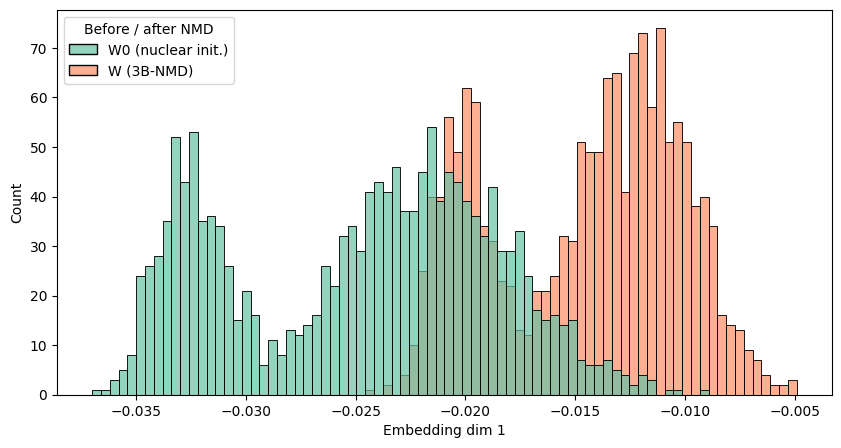

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim1_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_1",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 1")

plt.savefig(f"{figure_path}/histogram_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

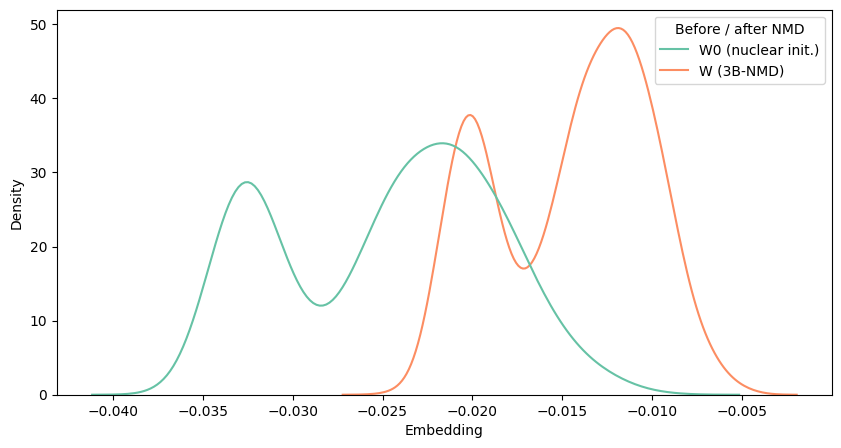

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_1", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

In [65]:
W0.flatten()

array([-0.02220467, -0.03433331, -0.02342435, ..., -0.01867731,
       -0.0252397 , -0.01867377])

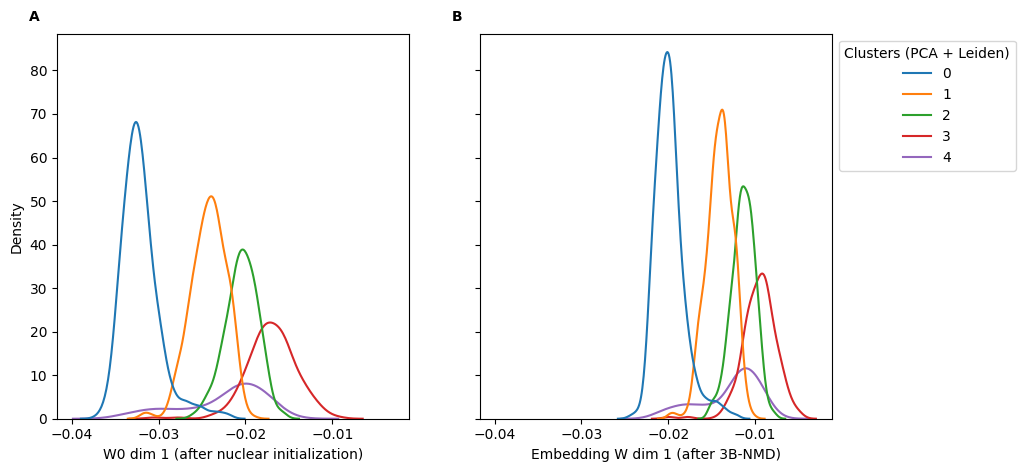

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(x=W0.flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False)
ax1.set_xlabel("W0 dim 1 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 1 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))


plt.savefig(
    f"{figure_path}/kde_W0_dim1_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

#### NMD embeddings vs. sequencing depth

Embeddings dimension vs. sequencing depth.

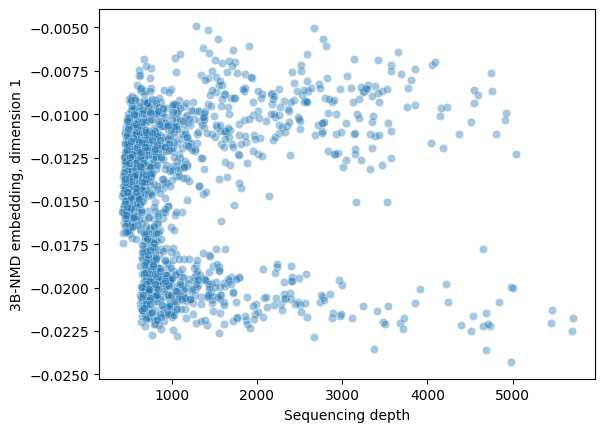

In [72]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 1")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim1.svg", format="svg")
plt.show()

In [74]:
corr_dim2_seqdepth = np.corrcoef(
    data.obsm["X_nmd"].flatten(), data.obs["total_counts"]
)[0][1]

print(
    f"Correlation between embedding dim 1 and sequencing depth: {corr_dim2_seqdepth:.3f}"
)

Correlation between embedding dim 1 and sequencing depth: 0.041


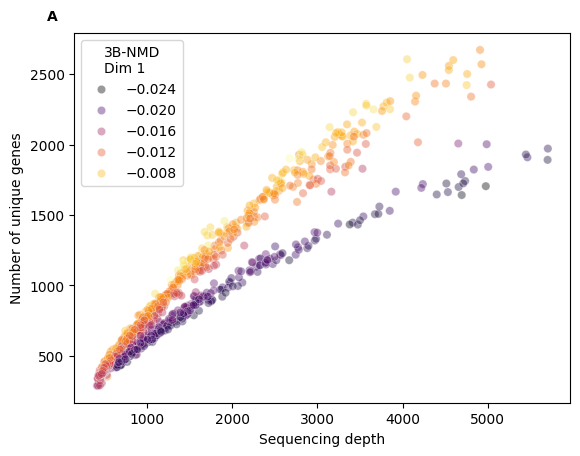

In [75]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, :1].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax,
)
ax.set_ylabel("Number of unique genes")
ax.set_xlabel("Sequencing depth")
ax.legend_.set_title("3B-NMD\nDim 1")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax.text(
    0.0,
    1.0,
    "A",
    transform=ax.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
plt.savefig(f"{figure_path}/sequencingdepth_uniquegenes_hueNMD.svg", format="svg")
plt.show()

#### NMD "components" vs. mean counts

NMD "components" are `p x k`, where `p` is the number of columns in the original data and `k` is the number of NMD latent dimensions.

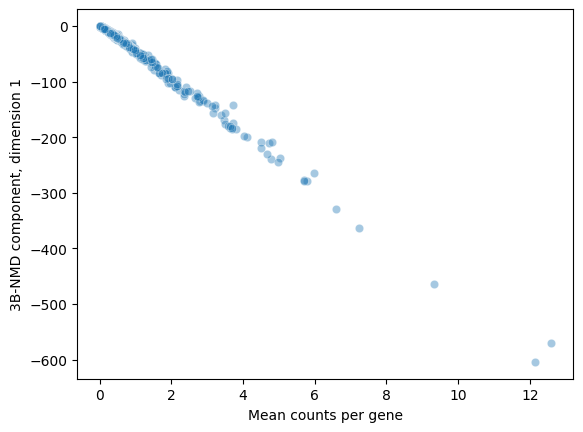

In [76]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 1")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp1.svg", format="svg")
plt.show()

In [78]:
corr_comp_meancountspergene = np.corrcoef(
    data.varm["nmd_components"].flatten(), data.var["mean_counts"]
)[0][1]

print(
    f"Correlation between embedding component 1 and mean counts per gene: {corr_comp_meancountspergene:.3f}"
)

Correlation between embedding component 1 and mean counts per gene: -0.998


#### NMD embeddings vs. PCs

Colored by clustering found using PCA + Leiden

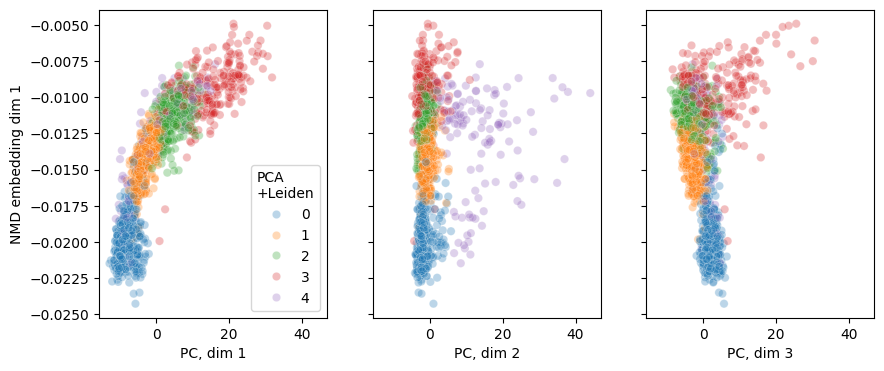

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 1")
ax1.legend_.set_title("PCA\n+Leiden")

sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_visible(None)

plt.show()

In [80]:
data.write(data_path + "/nmd_normalized_counts.h5ad")